In [1]:
# -*- coding: utf-8 -*-
"""
@author: Amin
"""

import sys
sys.path.insert(1, '../')

import models
import jax.numpy as jnp
import jax

import inference
import visualizations
import utils
import loader
from sklearn.covariance import EmpiricalCovariance

import os 
%load_ext autoreload
%autoreload 2

/Users/victorgeadah_maciii/anaconda3/envs/fi_gp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Run simulation
data_params = {
    'dt':.05,
    'sigma':.1,
    'ntrials':20,
    'time':5,
    'cohs':[-.5,.5],
    'seed': 10,
    'props':{'train':.8,'test':.1,'validation':.1},
    'seeds':{'train':2,'test':0,'validation':3},
    'N':2,
    'obs_noise':0.
}

dataloader = loader.Saddle(data_params)
_,ts = dataloader.load_train_data()
y = dataloader.data['x_train']

In [3]:
# _y, _ts = dataloader.load_train_data()
# print(_ts.shape)
# print(_y.shape) # Cx + eps, shape (batch_size (=ntrials * props['train']), steps, dim)

# print(dataloader.cond_avg.shape)
# import matplotlib.pyplot as plt
# # for i in range(10):
# #     plt.plot(*_y[i,1:].T, c='k')

# plt.plot(dataloader.cond_avg[0,:,0], dataloader.cond_avg[0,:,1]);
# plt.plot(dataloader.cond_avg[1,:,0], dataloader.cond_avg[1,:,1]);

In [4]:
# %%
model_params={
    'D':2,
    'seed':0,
    'kernel_A': [{'type':'RBF','scale': 1e0,'sigma': 10.,'normalizer': 1.}], #use 1e-2, 100 for LineAttractor and PointAttractor
    'kernel_A_diag': 1e-5,
    'kernel_b': [{'type':'RBF','scale': 1e-3,'sigma': 10.,'normalizer': 1.}], # use .1 for LineAttractor and PointAttractor
    'kernel_b_diag': 1e-5,
    'kernel_L': [{'type':'RBF','scale': data_params['dt']*data_params['sigma'],'sigma': 100.,'normalizer': 1.}],
    'kernel_L_diag': 1e-5,
    'obs_noise':0.,

}

optim_params = {
    'n_iter': 2000,
    'step_size': 1e-3,
    'gamma': 1,
    'scale_L':model_params['kernel_L'][0]['scale'],
}

model = dataloader.__class__.__name__
file='../results/demo/'+model+'/'
save=False

if not os.path.exists(file): os.makedirs(file)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


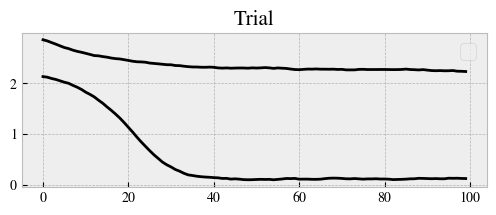

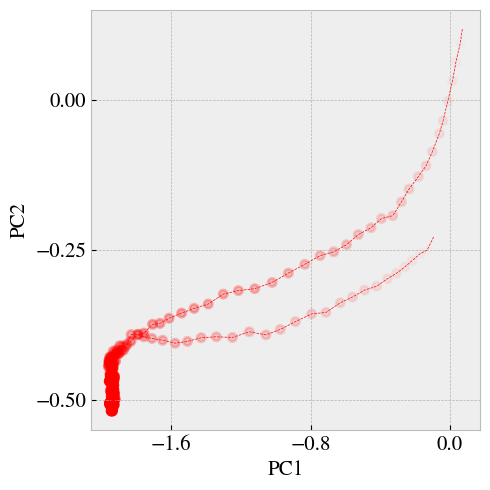

In [5]:
visualizations.plot_signals(
    [y[0]],
    titlestr='Trial',
    save=save,
    file=file+'trial'
)

B,T,N = y.shape
D = model_params['D']

if hasattr(dataloader,'A'):
    visualizations.time_var_dynamics(
        dataloader.A[None,:,:][[0]],
        titlestr=model+' (True)',
        scale=.1/jnp.abs(dataloader.A).max(),
        xlim=[-1,1],
        ylim=[-.2,.2],
        save=save,
        file=file+'A_true'
    )

visualizations.plot_states(
    [y[0],y[1]],
    ['y','y'],
    legend=False,
    save=save,
    file=file+'states'
)

In [6]:
# Constructing generative model compartments

seed = model_params['seed']
key = jax.random.PRNGKey(seed)

initial = models.InitialCondition(
    D,
    scale_tril=jnp.std(y[:,0,0])*jnp.eye(D)
)

lds = models.TimeVarLDS(
    D=D,
    initial=initial,
)

k1,key = jax.random.split(key,2)

emission = models.LinearEmission(
    key=k1,D=D,N=N,
    C=jnp.eye(D),
    d=jnp.zeros(D)
)

kernel_A = utils.get_kernel(model_params['kernel_A'],model_params['kernel_A_diag'])
kernel_b = utils.get_kernel(model_params['kernel_b'],model_params['kernel_b_diag'])
kernel_L = utils.get_kernel(model_params['kernel_L'],model_params['kernel_L_diag'])

gps = {
    'A': models.GaussianProcess(kernel_A,D,D),
    'b': models.GaussianProcess(kernel_b,D,1),
    'L': models.GaussianProcess(kernel_L,D,D)
}
print(ts[0])

print(gps['A'].sample(key,ts[0])[...,0])
print(gps['A'].sample(key,ts[0])[...,-1])


likelihood = models.NormalConditionalLikelihood(
    N,
    scale_tril=model_params['obs_noise']*jnp.eye(N)
)
joint = models.GPLDS(
    gps,
    lds,
    emission,
    likelihood
)

[0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35 1.4
 1.45 1.5  1.55 1.6  1.65 1.7  1.75 1.8  1.85 1.9  1.95 2.   2.05 2.1
 2.15 2.2  2.25 2.3  2.35 2.4  2.45 2.5  2.55 2.6  2.65 2.7  2.75 2.8
 2.85 2.9  2.95 3.   3.05 3.1  3.15 3.2  3.25 3.3  3.35 3.4  3.45 3.5
 3.55 3.6  3.65 3.7  3.75 3.8  3.85 3.9  3.95 4.   4.05 4.1  4.15 4.2
 4.25 4.3  4.35 4.4  4.45 4.5  4.55 4.6  4.65 4.7  4.75 4.8  4.85 4.9
 4.95]
[[ 0.30070692  0.95760864]
 [-1.5045441   1.2961309 ]]
[[ 0.06184224  0.7991038 ]
 [-2.2647474   1.1573932 ]]


In [7]:
# Constructing recognition model
k1,key = jax.random.split(key,2)

delta = inference.DeltaZ(
    k1,D,T,
    scale_L=optim_params['scale_L'],
)

ELBO: -1014.67, Log Marginal: 733.63, Log Prior: 281.04: 100%|██████████| 2000/2000 [00:40<00:00, 49.18it/s]


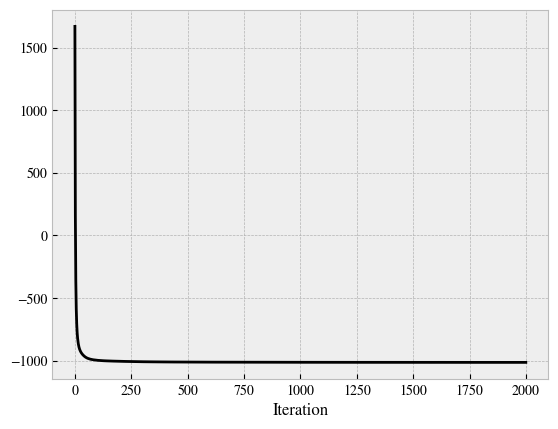

In [8]:
# Running inference
loss = inference.map(
    joint,
    delta,
    y,
    ts,
    n_iter=optim_params['n_iter'],
    step_size=optim_params['step_size'],
    gamma=optim_params['gamma']
)

# Plotting the marginal likelihood loss
visualizations.plot_loss(
    loss,
    save=save,
    file=file+'loss'
)

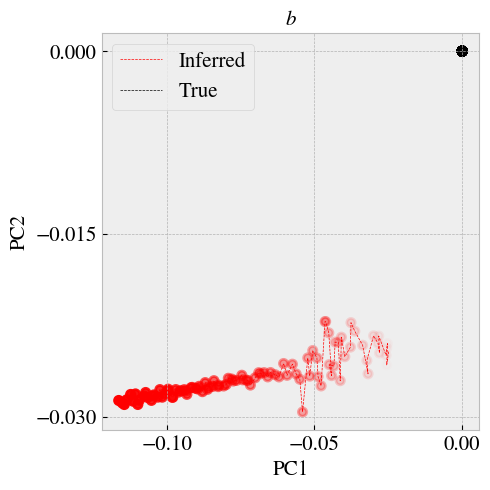

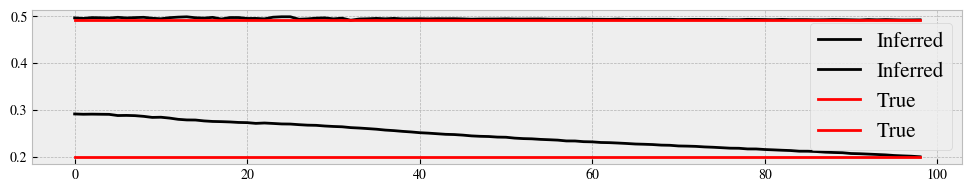

In [9]:
# Inspecting the posterior (which is delta distribution in this case)
(EA,Eb,EL) = delta.posterior_mean(y[0],ts[0],delta.params)

# Visualizing inferred inputs
if 'b_train' in dataloader.data:
    visualizations.plot_states(
        [Eb,dataloader.data['b_train'][0]],
        ['Inferred','True'],
        titlestr='$b$',
        save=save,
        file=file+'b_states'
    )

    visualizations.plot_signals(
        [Eb,dataloader.data['b_train'][0]],
        labels=['Inferred','True'],
        margin=.2,
        save=save,
        file=file+'b_signals'
    )

/mnt/home/anejatbakhsh/Desktop/Projects/GPLDS/codes/notebooks/../visualizations.py:176: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(
/mnt/home/anejatbakhsh/Desktop/Projects/GPLDS/codes/notebooks/../visualizations.py:176: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


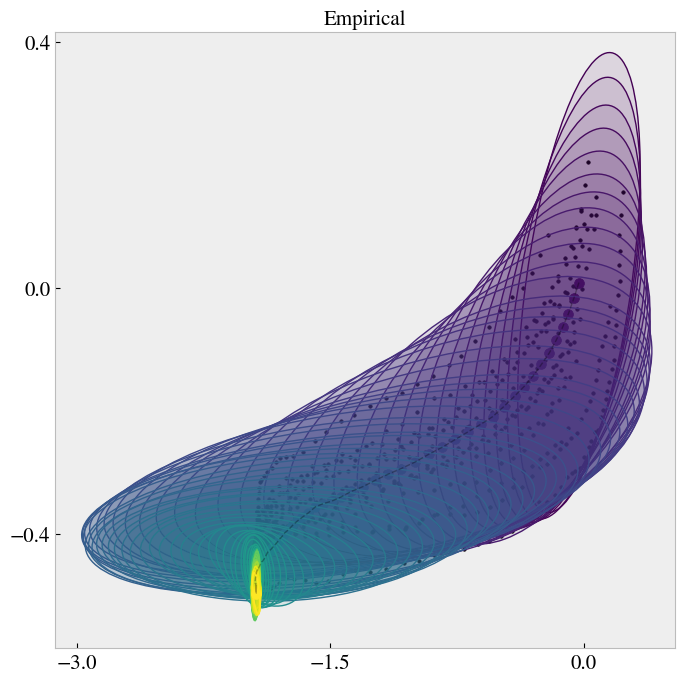

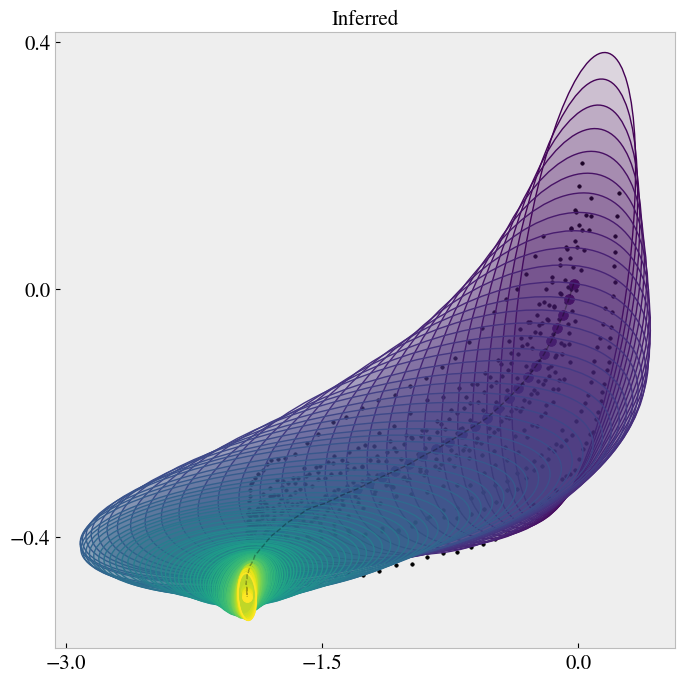

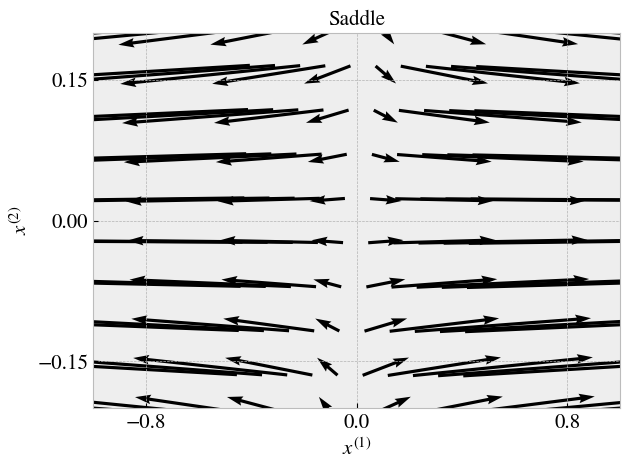

In [10]:
# Visualizing inferred dynamics and mean trajectories
mus,sigmas = lds.evolve_stats(EA,Eb,EL)

sigmas_obs = jnp.array([
    emission.C@sigmas[i]@emission.C.T + \
    likelihood.scale_tril@likelihood.scale_tril.T
    for i in range(len(sigmas))])
mus_obs = (emission.C @ mus.T).T

sigmas_empirical = jnp.array(
    [EmpiricalCovariance().fit(y[:,t]).covariance_ 
     for t in range(T)]
)

mus_empirical = y.mean(0)

visualizations.visualize_pc(
    mus_empirical[:,None],sigmas_empirical,
    pc=y,
    linewidth=1,
    titlestr='Empirical',
    save=save,
    file=file+'pc_emp'
)


visualizations.visualize_pc(
    mus_obs[:,None],sigmas_obs,
    pc=y,
    linewidth=1,
    titlestr='Inferred',
    save=save,
    file=file+'pc_inferred'
)


visualizations.time_var_dynamics(
    EA-jnp.eye(D)[None],
    titlestr=model,
    scale=5/EA.max(),
    xlim=[-1,1],
    ylim=[-.2,.2],
    save=False,
    file=file+'A'
)